## Prep

In [1]:
##### import packages
#base
import os
import sys
from collections import defaultdict
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt
import random
import pyreadr
import pandas as pd
import seaborn as sns
%matplotlib inline
%autosave 30

#pyro contingency
import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete, Predictive
from pyro.ops.indexing import Vindex
from pyro.infer import MCMC, NUTS
import torch
from torch.distributions import constraints
pyro.enable_validation(True)

#misc
import pickle
import torch.nn.functional as F
import itertools
import time
# import umap
# import plotly
# import plotly.graph_objs as go

# import homebrew modules
import tomtom_models as tm
import tomtom_util as tu

# some useless warnings from seaborn, suppressing here
import warnings
warnings.filterwarnings("ignore")

Autosaving every 30 seconds


In [2]:
# import data and previously fitted parameters
# import pickled data
with open('tomtom_data_preprocessed.pkl','rb') as f:
    [tself_norm_all_3d, tself_norm_noauto_3d, tself_raw_all_3d, tself_raw_noauto_3d,
    ttarg_norm_all_3d, ttarg_norm_noauto_3d, ttarg_raw_all_3d, ttarg_raw_noauto_3d,
    tavg_norm_all_3d, tavg_norm_noauto_3d, tavg_raw_all_3d, tavg_raw_noauto_3d] = pickle.load(f)
# import fitted models from the varying-k analyses
with open('tomtom_fitted_models.pkl','rb') as f:
    [seeds_self_norm_all_grp,maps_self_norm_all_grp,logprobs_self_norm_all_grp,mems_self_norm_all_grp,
     seeds_self_norm_all_dim,maps_self_norm_all_dim,logprobs_self_norm_all_dim,
     seeds_self_norm_noauto_grp,maps_self_norm_noauto_grp,logprobs_self_norm_noauto_grp,mems_self_norm_noauto_grp,
     seeds_self_norm_noauto_dim,maps_self_norm_noauto_dim,logprobs_self_norm_noauto_dim,
     seeds_self_raw_all_grp,maps_self_raw_all_grp,logprobs_self_raw_all_grp,mems_self_raw_all_grp,
     seeds_self_raw_all_dim,maps_self_raw_all_dim,logprobs_self_raw_all_dim,
     seeds_self_raw_noauto_grp,maps_self_raw_noauto_grp,logprobs_self_raw_noauto_grp,mems_self_raw_noauto_grp,
     seeds_self_raw_noauto_dim,maps_self_raw_noauto_dim,logprobs_self_raw_noauto_dim] = pickle.load(f)

## Data generation

Data generation is done on the cluster through model_recovery_data_gen script in cluster_script/model_recovery/

## Refitting the models
Data generation is done on the cluster through model_recovery_*_*_* scripts in cluster_script/model_recovery/

## Evaluating refitted parameters

In [3]:
# code to summarize param recovery
# first read in the refitted paramter files
def read_refit_cross_param(norm,auto,mtype):
    seeds = []
    maps = []
    logprobs = []
    maxk = 10
    for i in np.arange(maxk):
        fname = 'modrec_self_{}_{}_{}_cross_k{}.pkl'.format(norm,auto,mtype,i)
        with open(fname, 'rb') as f:
            [sk,mk,lpk] = pickle.load(f)
        seeds.append(sk)
        maps.append(mk)
        logprobs.append(lpk)
        print('done reading from {}'.format(fname))
    return seeds, maps, logprobs

In [4]:
seeds_self_norm_all_dim_refit_cross, maps_self_norm_all_dim_refit_cross, logprobs_self_norm_all_dim_refit_cross = \
read_refit_cross_param('norm','all','dim')
seeds_self_norm_all_grp_refit_cross, maps_self_norm_all_grp_refit_cross, logprobs_self_norm_all_grp_refit_cross = \
read_refit_cross_param('norm','all','grp')
seeds_self_norm_noauto_dim_refit_cross, maps_self_norm_noauto_dim_refit_cross, logprobs_self_norm_noauto_dim_refit_cross = \
read_refit_cross_param('norm','noauto','dim')
seeds_self_norm_noauto_grp_refit_cross, maps_self_norm_noauto_grp_refit_cross, logprobs_self_norm_noauto_grp_refit_cross = \
read_refit_cross_param('norm','noauto','grp')
seeds_self_raw_all_grp_refit_cross, maps_self_raw_all_grp_refit_cross, logprobs_self_raw_all_grp_refit_cross = \
read_refit_cross_param('raw','all','grp')
seeds_self_raw_all_dim_refit_cross, maps_self_raw_all_dim_refit_cross, logprobs_self_raw_all_dim_refit_cross = \
read_refit_cross_param('raw','all','dim')
seeds_self_raw_noauto_grp_refit_cross, maps_self_raw_noauto_grp_refit_cross, logprobs_self_raw_noauto_grp_refit_cross = \
read_refit_cross_param('raw','noauto','grp')
seeds_self_raw_noauto_dim_refit_cross, maps_self_raw_noauto_dim_refit_cross, logprobs_self_raw_noauto_dim_refit_cross = \
read_refit_cross_param('raw','noauto','dim')

done reading from modrec_self_norm_all_dim_cross_k0.pkl
done reading from modrec_self_norm_all_dim_cross_k1.pkl
done reading from modrec_self_norm_all_dim_cross_k2.pkl
done reading from modrec_self_norm_all_dim_cross_k3.pkl
done reading from modrec_self_norm_all_dim_cross_k4.pkl
done reading from modrec_self_norm_all_dim_cross_k5.pkl
done reading from modrec_self_norm_all_dim_cross_k6.pkl
done reading from modrec_self_norm_all_dim_cross_k7.pkl
done reading from modrec_self_norm_all_dim_cross_k8.pkl
done reading from modrec_self_norm_all_dim_cross_k9.pkl
done reading from modrec_self_norm_all_grp_cross_k0.pkl
done reading from modrec_self_norm_all_grp_cross_k1.pkl
done reading from modrec_self_norm_all_grp_cross_k2.pkl
done reading from modrec_self_norm_all_grp_cross_k3.pkl
done reading from modrec_self_norm_all_grp_cross_k4.pkl
done reading from modrec_self_norm_all_grp_cross_k5.pkl
done reading from modrec_self_norm_all_grp_cross_k6.pkl
done reading from modrec_self_norm_all_grp_cross

## Looking at parameter correlation,  only corresponding Ks

In [5]:
# define a function that computes parameter correspondence metrics for one type of model
def get_cross_cormat(real,refit):
    #first extract only the parameters to be compared
    bad_keys = ['topic_weights','weights','participant_topics']
    good_keys = list(set(real.keys()) - set(bad_keys))
    nfactor = real[good_keys[0]].shape[0]
    nitem = real[good_keys[0]].shape[1] * real[good_keys[0]].shape[2]
    if 'concentration' in good_keys or 'topic_concentration' in good_keys: # meaning dealing with normalized data
        preal = [real[key].detach().numpy().reshape(nfactor,nitem) for key in good_keys]
        prefit = [refit[key].detach().numpy().reshape(nfactor,nitem) for key in good_keys]
    elif 'alpha' in good_keys or 'topic_a' in good_keys: # dealing with raw data
        preal = [real[key].detach().numpy().reshape(nfactor,nitem) for key in good_keys]
        prefit = [refit[key].detach().numpy().reshape(nfactor,nitem) for key in good_keys]
    keymap = dict(zip(['topic_a','alpha','topic_b','beta','topic_concentration','concentration'],
                      ['a','a','b','b','conc','conc']))   #create index map 
    param_cor = dict(zip(['a','b','conc'], # init return dict
                        [np.nan,np.nan,np.nan]))
#     print(len(preal))
    for key in good_keys:
        mat = tu.cross_matrix_pairwise(preal[good_keys.index(key)],prefit[good_keys.index(key)])
#         np.fill_diagonal(mat,np.nan)
        param_cor[keymap[key]] = mat
    return param_cor

def cor_mat_means(param_cor):
    row = []
    for i in param_cor.keys():
        mat = param_cor[i]
        if type(mat) is not float:
            meancor = mat.mean()
            meanmaxrow = mat.max(axis = 0).mean()
            meanmaxcol = mat.max(axis = 1).mean() 
            row.extend([meancor,meanmaxrow,meanmaxcol])
        else:
            row.extend([np.nan,np.nan,np.nan])
#     print(row)
    return row


def param_cors(maps_real,maps_refit):
    #first make empty df for storag
    n_sample_array = np.concatenate((np.arange(10,160,15), np.arange(200,600,100)))
    n_rep = 5 # change this if it's changed in the datagen script
    k = np.repeat(np.arange(len(maps_real)),n_sample_array.shape[0]*n_rep) + 1
    nsample = np.tile(np.repeat(n_sample_array,n_rep),len(maps_real))
    rep = np.tile(np.arange(n_rep),n_sample_array.shape[0]*len(maps_real))
    additional_cols = np.array([rep,nsample,k]).transpose()
    #fill the df
    all_blocks = []
    for i in range(len(maps_real)):
        real = maps_real[i]
        refits = maps_refit[i][i] # refit contains 14 dicts, one for each sample size
        k_block = []
        for refit_reps in refits:
            nsample_block = []
            for refit in refit_reps:
                param_cor = get_cross_cormat(real,refit)
                nsample_block.append(cor_mat_means(param_cor))
            k_block.extend(nsample_block)
#             print(np.array(k_block).shape)
        all_blocks.extend(k_block)
    all_blocks = np.array(all_blocks)
    # assemble and return the df
    columns = ['a_mean','a_meanmaxrow','a_meanmaxcol',
               'b_mean','b_meanmaxrow','b_meanmaxcol',
               'c_mean','c_meanmaxrow','c_meanmaxcol',
               'rep','nsample','k']
    return pd.DataFrame(data = np.hstack((all_blocks,additional_cols)),columns = columns)

def draw_param_cors(df,param,metric):
    """
    df: df of param cor
    param: str, a/b/c
    metric: str, mean/meanmaxrow/meanmaxcol
    """
    col = f'{param}_{metric}'
    df = df.groupby(['k','nsample'],as_index = False).aggregate('mean')
    g = sns.lineplot(x = df['nsample'],y=df[col],hue=df['k'],legend = False)


### Normalized, with autotransitions

For an example, pretty much the same thing across all model types

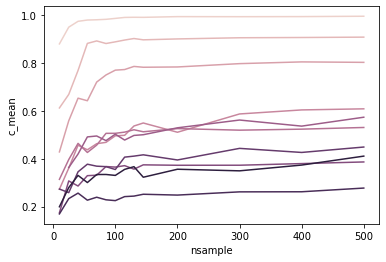

In [6]:
#grp
dfparam = param_cors(maps_self_norm_all_grp,maps_self_norm_all_grp_refit_cross)
draw_param_cors(dfparam,'c','mean')

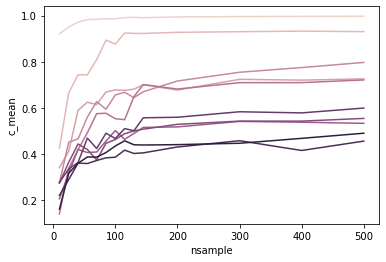

In [7]:
#dim
dfparam = param_cors(maps_self_norm_all_dim,maps_self_norm_all_dim_refit_cross)
draw_param_cors(dfparam,'c','mean')

## Data K model K crossed - graphing log prob

In [8]:
# convert list of log probs into a long format dataframe
n_sample_array = np.concatenate((np.arange(10,160,15), np.arange(200,600,100)))
def logprobs_ls2df_cross(ls):
    maxk = 10
    stor = []
    for nsind in np.arange(len(n_sample_array)):
       stor.append(torch.cat([torch.stack([torch.stack(modelk[nsind]).mean() for modelk in datak]) for datak in ls]))
    logprobs = torch.cat(stor)
    nsample = np.repeat(n_sample_array,maxk*maxk)
    modelk = np.tile(np.arange(maxk)+1,maxk*len(n_sample_array))
    datak = np.tile(np.repeat(np.arange(maxk)+1,maxk),len(n_sample_array))
    datanp = np.stack([logprobs,modelk,datak,nsample]).transpose()
    return pd.DataFrame(data = datanp, columns=['logprobs','modelk','datak','nsample'])
    

In [9]:
lpdf_self_norm_all_grp_refit_cross = logprobs_ls2df_cross(logprobs_self_norm_all_grp_refit_cross)
lpdf_self_norm_all_dim_refit_cross = logprobs_ls2df_cross(logprobs_self_norm_all_dim_refit_cross)
lpdf_self_norm_noauto_grp_refit_cross = logprobs_ls2df_cross(logprobs_self_norm_noauto_grp_refit_cross)
lpdf_self_norm_noauto_dim_refit_cross = logprobs_ls2df_cross(logprobs_self_norm_noauto_dim_refit_cross)
lpdf_self_raw_all_grp_refit_cross = logprobs_ls2df_cross(logprobs_self_raw_all_grp_refit_cross)
lpdf_self_raw_all_dim_refit_cross = logprobs_ls2df_cross(logprobs_self_raw_all_dim_refit_cross)
lpdf_self_raw_noauto_grp_refit_cross = logprobs_ls2df_cross(logprobs_self_raw_noauto_grp_refit_cross)
lpdf_self_raw_noauto_dim_refit_cross = logprobs_ls2df_cross(logprobs_self_raw_noauto_dim_refit_cross)

### Normalized, with autotransitions

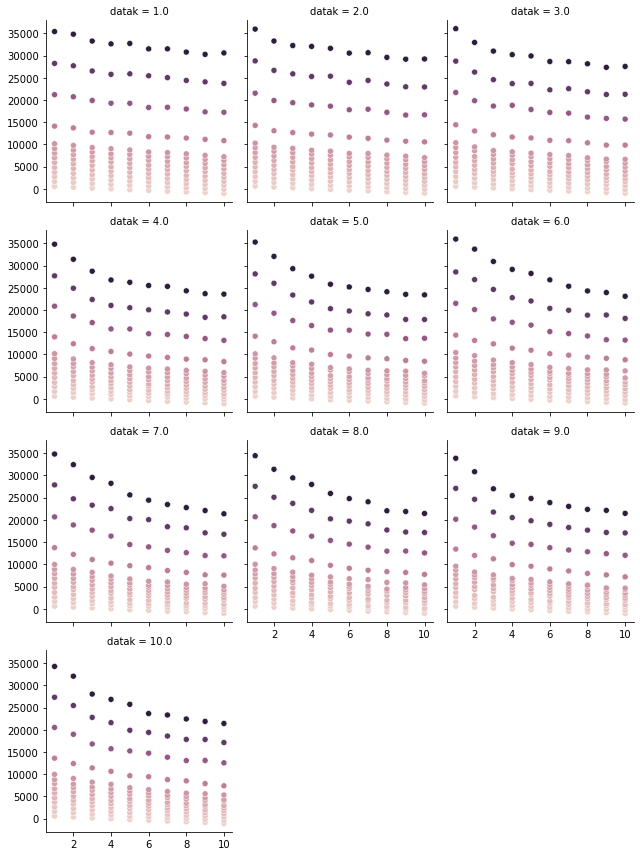

In [10]:
#grp
g = sns.FacetGrid(lpdf_self_norm_all_grp_refit_cross, col = 'datak',col_wrap = 3)
g.map_dataframe(sns.scatterplot, x = 'modelk', y = 'logprobs', hue = 'nsample')

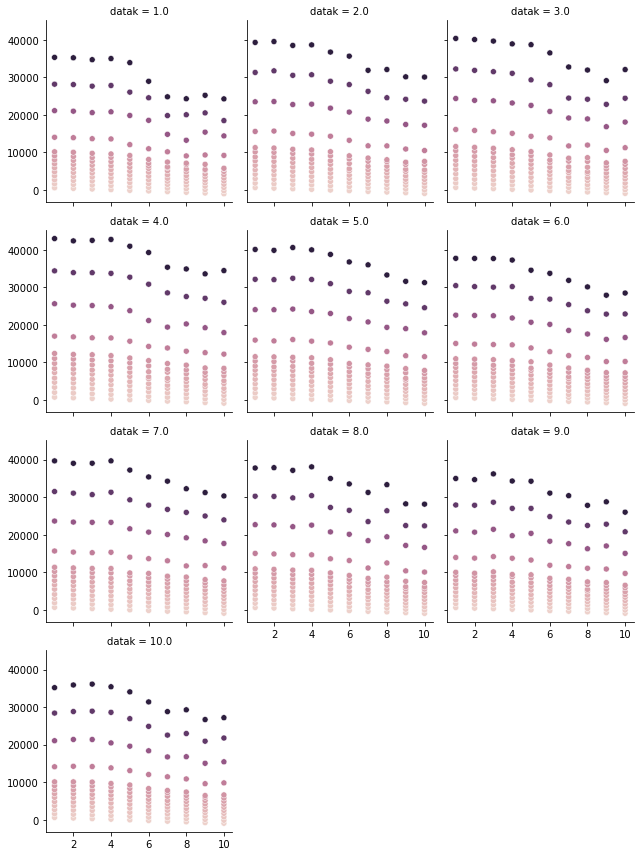

In [11]:
# dim
g = sns.FacetGrid(lpdf_self_norm_all_dim_refit_cross, col = 'datak',col_wrap = 3)
g.map_dataframe(sns.scatterplot, x = 'modelk', y = 'logprobs', hue = 'nsample')

### Normalized, without autotransitions

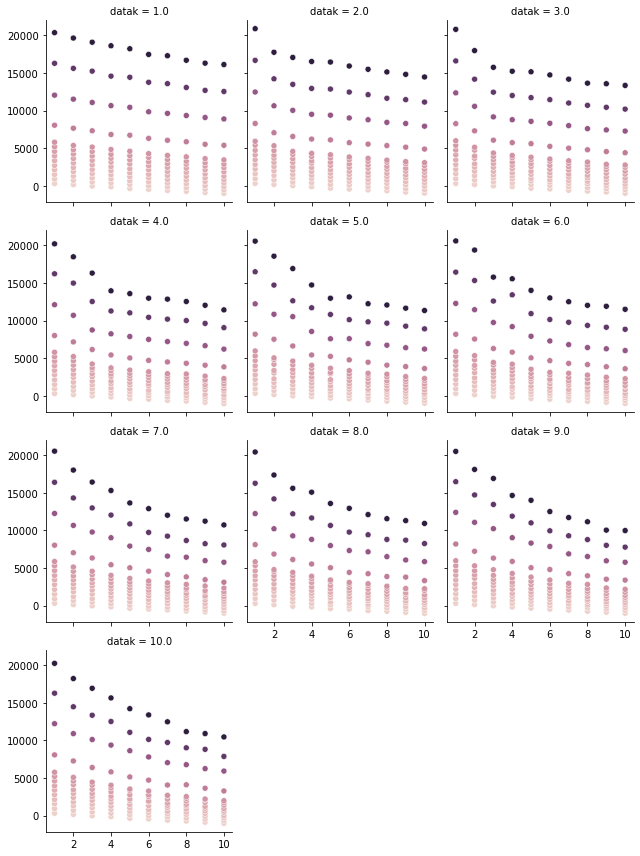

In [12]:
#grp
g = sns.FacetGrid(lpdf_self_norm_noauto_grp_refit_cross, col = 'datak',col_wrap = 3)
g.map_dataframe(sns.scatterplot, x = 'modelk', y = 'logprobs', hue = 'nsample')

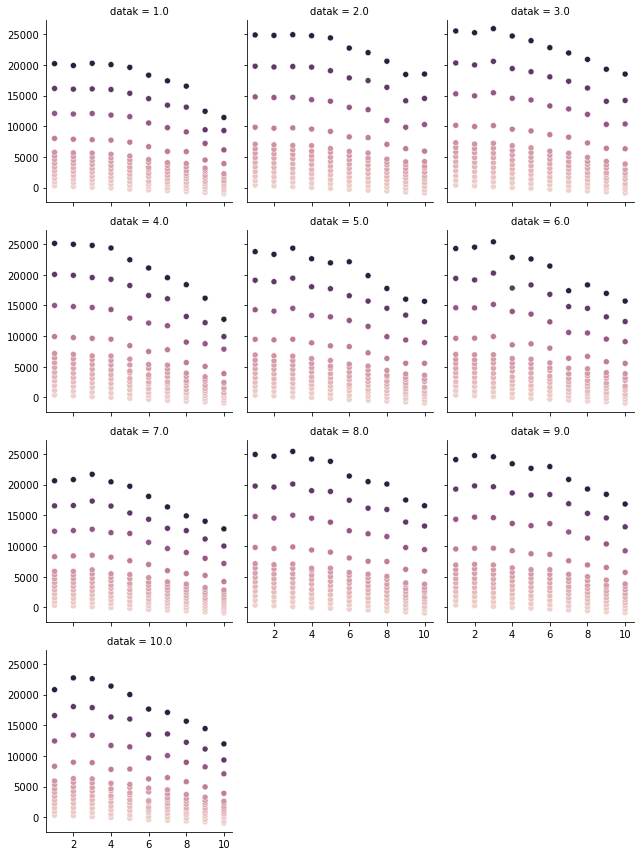

In [13]:
# dim
g = sns.FacetGrid(lpdf_self_norm_noauto_dim_refit_cross, col = 'datak',col_wrap = 3)
g.map_dataframe(sns.scatterplot, x = 'modelk', y = 'logprobs', hue = 'nsample')

### Raw, with autotransitions

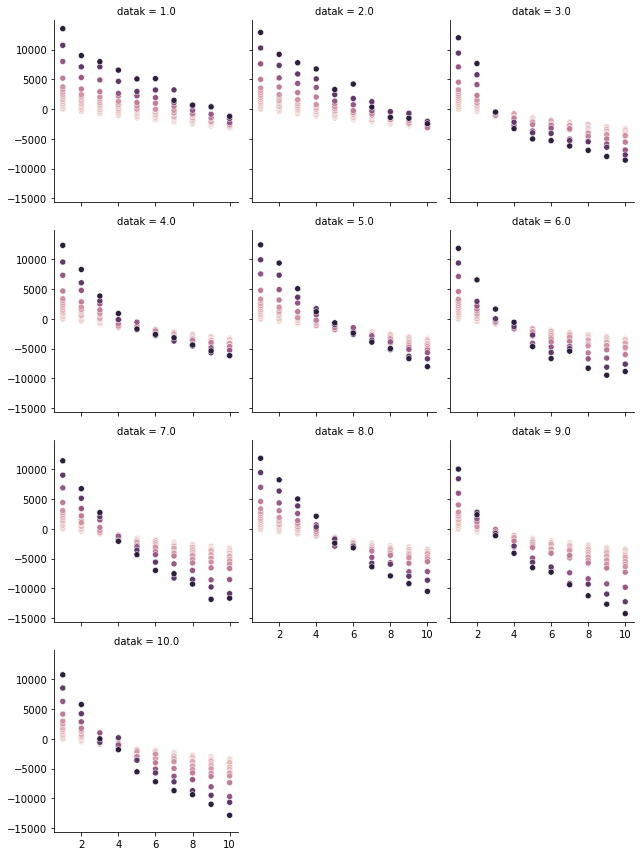

In [14]:
#grp
g = sns.FacetGrid(lpdf_self_raw_all_grp_refit_cross, col = 'datak',col_wrap = 3)
g.map_dataframe(sns.scatterplot, x = 'modelk', y = 'logprobs', hue = 'nsample')

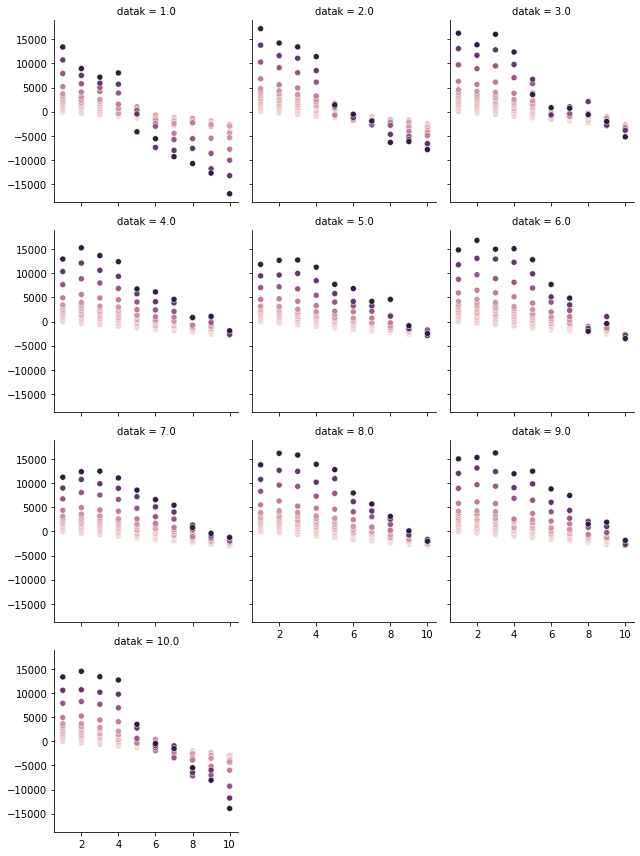

In [15]:
# dim
g = sns.FacetGrid(lpdf_self_raw_all_dim_refit_cross, col = 'datak',col_wrap = 3)
g.map_dataframe(sns.scatterplot, x = 'modelk', y = 'logprobs', hue = 'nsample')

### Raw, without autotransitions

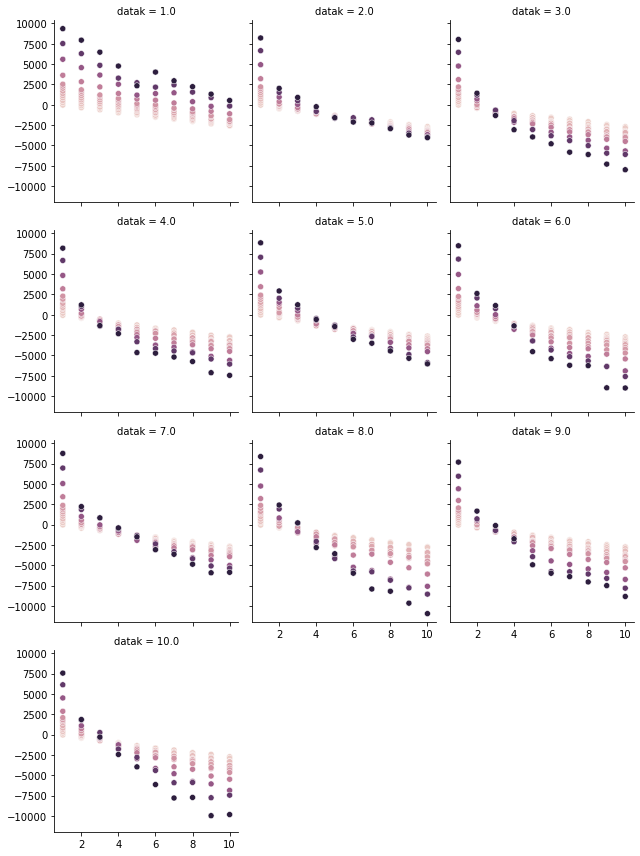

In [16]:
# raw noauto grp
g = sns.FacetGrid(lpdf_self_raw_noauto_grp_refit_cross, col = 'datak',col_wrap = 3)
g.map_dataframe(sns.scatterplot, x = 'modelk', y = 'logprobs', hue = 'nsample')

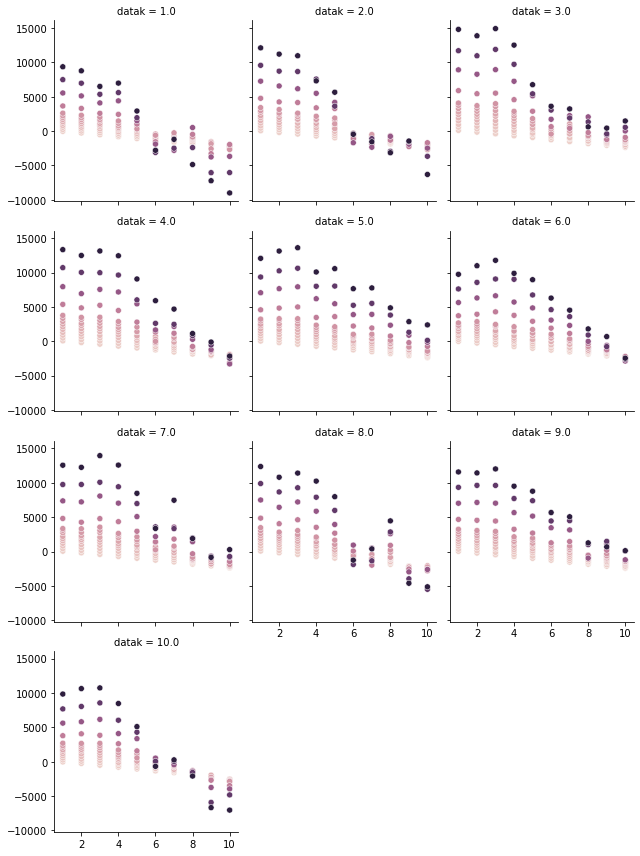

In [17]:
# raw noauto dim
g = sns.FacetGrid(lpdf_self_raw_noauto_dim_refit_cross, col = 'datak',col_wrap = 3)
g.map_dataframe(sns.scatterplot, x = 'modelk', y = 'logprobs', hue = 'nsample')